# Model training
- **LightGBM** classifier, feature selection for top 15 features.
- **Hyperparameter optimization** with **Optuna**, simulating time-dependent constraints.
- **Model Evaluation**:
  - **AUC**: 80.08% on test set  
  - F1: 0.75, Precision: 0.66, Recall: 0.87
- **Feature importance** analyzed with **SHAP values**.
- Temporal-aware cross-validation ensures realistic performance.

In [96]:
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score
import xgboost as xgb
from scipy.stats import uniform, randint, loguniform
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn import metrics
import matplotlib.pyplot as plt
import utils.utils as utils
import shap

In [5]:
train = pd.read_parquet('data/train_data.parquet')
test = pd.read_parquet('data/test_data.parquet')

In [6]:
y_train = train.pop('TARGET')
X_train = train.copy()

y_test = test.pop('TARGET')
X_test = test.copy()

In [7]:
del train, test

In [8]:
y_train.value_counts()/len(y_train)

0    0.501407
1    0.498593
Name: TARGET, dtype: float64

In [9]:
y_test.value_counts()/len(y_test)

1    0.506546
0    0.493454
Name: TARGET, dtype: float64

### Initial feature selection
First, I'm going to discard features that don't add predictive power

In [10]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [22]:
lgbm = LGBMClassifier()

In [23]:
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8504212, number of negative: 8552195
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.962591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3294
[LightGBM] [Info] Number of data points in the train set: 17056407, number of used features: 62
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.498593 -> initscore=-0.005626
[LightGBM] [Info] Start training from score -0.005626


LGBMClassifier()

In [27]:
y_pred = lgbm.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred)
print(f"Initial AUC test: {auc:.4f}")

Initial AUC test: 0.7994


In [46]:
importance = lgbm.booster_.feature_importance(importance_type='gain')
feature_names = X_train.columns

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importance
}).sort_values(by='importance', ascending=False)

print(feat_imp.head(10).round())

                            feature  importance
18       movie_mean_previous_target   9629355.0
6              mean_previous_target   8172521.0
14                movie_mean_rating   4664458.0
0                       prev_rating   1651235.0
2                      mean_ratings    921963.0
1                  num_prev_ratings    570607.0
7   num_prev_ratings_greater_than_4    224090.0
13           num_movie_prev_ratings    222028.0
12        seconds_since_last_rating    177233.0
11                             year    176810.0


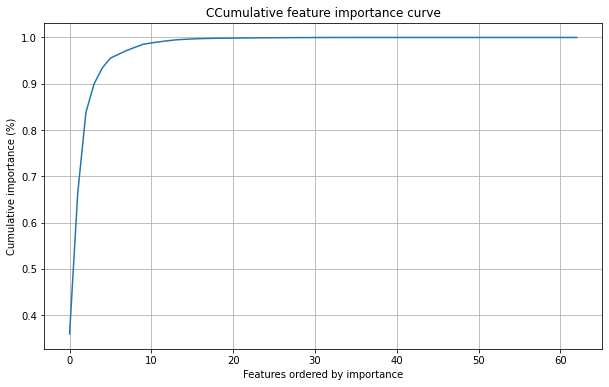

In [47]:
feat_imp_sorted = feat_imp.sort_values(by="importance", ascending=False)
plt.figure(figsize=(10,6))
plt.plot(range(len(feat_imp_sorted)), feat_imp_sorted['importance'].cumsum() / feat_imp_sorted['importance'].sum())
plt.xlabel("Features ordered by importance")
plt.ylabel("Cumulative importance (%)")
plt.title("CCumulative feature importance curve")
plt.grid()
plt.show()


Based on this I'll tune the final model only using the best 15 features.

In [53]:
best_15_features = feat_imp_sorted['feature'][0:15].values

In [54]:
X_train = X_train[best_15_features]
X_test = X_test[best_15_features]

In [58]:
from sklearn.model_selection import KFold
import optuna

I'll only use a fraction of the data to find the best parameters

In [67]:
def subsample_data_ordered(X: pd.DataFrame, y: pd.Series, frac=0.1):
    """
    Subsample del dataset sin cambiar el orden, tomando una muestra uniforme.
    Esto lo hago porque ya tengo mi train/test ordenados por timestamp.
    Aparte de que quiero entrenar usando OOT.

    Parameters
    ----------
    X : pd.DataFrame
    y : pd.Series
    frac : float
        Fracción de filas a tomar (ej. 0.1 = 10%).

    Returns
    -------
    X_sub, y_sub : np.ndarray
        Submuestra de X e y, manteniendo el orden original.
    """
    n_total = len(X)
    n_sample = int(n_total * frac)
    
    # calcular step para tomar cada k-ésima fila
    step = max(1, n_total // n_sample)
    
    indices = np.arange(0, n_total, step)[:n_sample]  # asegura exactamente n_sample filas
    X_sub = X.iloc[indices, :].to_numpy(dtype=np.float32)
    y_sub = y.iloc[indices].to_numpy()
    
    return X_sub, y_sub


This functions find the best params for lightgbm, and also in the Cross-Validation only the upper half of the splits, to simulate this time dependence problem.

In [82]:
def objective_trial_oot(trial, X_sub, y_sub, cv_splits=4, tol=0.1):
    cv = KFold(n_splits=cv_splits, shuffle=True, random_state=42)

    # Param grid
    param_grid = {
        "objective": "binary",
        "boosting_type": "gbdt",
        "metric": "auc",
        "random_state": 42,
        "verbose": -1,
        "n_estimators": trial.suggest_int("n_estimators", 50, 500, step=50),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.3, step=0.05),
        "subsample": trial.suggest_float("subsample", 0.3, 0.7, step=0.05),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.7, step=0.05),
        "max_depth": trial.suggest_int("max_depth", 3, 8),
        "num_leaves": trial.suggest_int("num_leaves", 4, 16),
        "max_bin": trial.suggest_int("max_bin", 50, 255, step=10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10, step=1),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10, step=1),
        "n_jobs": -1
    }
    min_child_proportion = trial.suggest_float("min_child_proportion", 0.005, 0.1, step=0.005)

    # ---------------------------
    # OOT-style CV: only the upper half of the splits
    # ---------------------------
    cv_results = {"auc_train": [], "auc_val": []}
    splits = list(cv.split(X_sub))
    for train_idx, test_idx in splits[len(splits)//2:]:
        X_train, X_val = X_sub[train_idx], X_sub[test_idx]
        y_train, y_val = y_sub[train_idx], y_sub[test_idx]

        param_grid["min_child_samples"] = max(1, int(len(X_train) * min_child_proportion))

        lgbm = LGBMClassifier(**param_grid)
        lgbm.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_val, y_val)],
                eval_names=["train", "val"],
                eval_metric="auc",
                callbacks=[
                        lgb.early_stopping(stopping_rounds=10),
                        lgb.log_evaluation(period=0)]
        )
        
        cv_results["auc_train"].append(lgbm.best_score_["train"]["auc"])
        cv_results["auc_val"].append(lgbm.best_score_["val"]["auc"]) 

    # Penalizar overfitting
    auc_train = np.mean(cv_results["auc_train"])
    auc_test = np.mean(cv_results["auc_val"])
    auc_diff = auc_train / auc_test - 1

    objective = auc_test
    if auc_diff > tol:
        objective = 0.5

    return objective

In [69]:
X_sub, y_sub = subsample_data_ordered(X_train, y_train, frac=0.1)

### Optimize with Optuna

In [83]:
study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective_trial_oot(trial, X_sub, y_sub), n_trials=10)

[I 2026-02-01 15:54:34,263] A new study created in memory with name: no-name-5356af96-6ab0-4e62-92fc-f9b2e28e0b59
The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.791014	val's auc: 0.790545
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 15:55:14,663] Trial 0 finished with value: 0.7902657674526223 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'subsample': 0.5, 'colsample_bytree': 0.55, 'max_depth': 4, 'num_leaves': 14, 'max_bin': 120, 'reg_alpha': 5.0, 'reg_lambda': 1.0, 'min_child_proportion': 0.095}. Best is trial 0 with value: 0.7902657674526223.


Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.791478	val's auc: 0.789986


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.791314	val's auc: 0.790722
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 15:55:44,850] Trial 1 finished with value: 0.7903890240523295 and parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.5, 'max_depth': 8, 'num_leaves': 16, 'max_bin': 150, 'reg_alpha': 2.0, 'reg_lambda': 8.0, 'min_child_proportion': 0.045}. Best is trial 1 with value: 0.7903890240523295.


Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.791654	val's auc: 0.790056


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.794716	val's auc: 0.793964
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 15:56:29,056] Trial 2 finished with value: 0.7936387020148215 and parameters: {'n_estimators': 150, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.4, 'max_depth': 8, 'num_leaves': 9, 'max_bin': 50, 'reg_alpha': 8.0, 'reg_lambda': 0.0, 'min_child_proportion': 0.01}. Best is trial 2 with value: 0.7936387020148215.


Did not meet early stopping. Best iteration is:
[150]	train's auc: 0.794944	val's auc: 0.793313


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[450]	train's auc: 0.795019	val's auc: 0.794088
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 15:58:35,899] Trial 3 finished with value: 0.793710993842367 and parameters: {'n_estimators': 450, 'learning_rate': 0.25, 'subsample': 0.45, 'colsample_bytree': 0.4, 'max_depth': 3, 'num_leaves': 14, 'max_bin': 160, 'reg_alpha': 3.0, 'reg_lambda': 8.0, 'min_child_proportion': 0.07}. Best is trial 3 with value: 0.793710993842367.


Did not meet early stopping. Best iteration is:
[450]	train's auc: 0.795332	val's auc: 0.793334


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	train's auc: 0.785741	val's auc: 0.785246
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 15:58:50,920] Trial 4 finished with value: 0.784884852594658 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'subsample': 0.3, 'colsample_bytree': 0.3, 'max_depth': 3, 'num_leaves': 7, 'max_bin': 170, 'reg_alpha': 7.0, 'reg_lambda': 0.0, 'min_child_proportion': 0.07}. Best is trial 3 with value: 0.793710993842367.


Did not meet early stopping. Best iteration is:
[50]	train's auc: 0.785961	val's auc: 0.784524


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[400]	train's auc: 0.797004	val's auc: 0.795742
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 16:01:14,936] Trial 5 finished with value: 0.7953636875128032 and parameters: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'subsample': 0.45, 'colsample_bytree': 0.65, 'max_depth': 6, 'num_leaves': 14, 'max_bin': 50, 'reg_alpha': 5.0, 'reg_lambda': 6.0, 'min_child_proportion': 0.045}. Best is trial 5 with value: 0.7953636875128032.


Did not meet early stopping. Best iteration is:
[400]	train's auc: 0.797251	val's auc: 0.794986


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[400]	train's auc: 0.792448	val's auc: 0.791951
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 16:03:44,670] Trial 6 finished with value: 0.7915031565086457 and parameters: {'n_estimators': 400, 'learning_rate': 0.05, 'subsample': 0.7, 'colsample_bytree': 0.6000000000000001, 'max_depth': 5, 'num_leaves': 8, 'max_bin': 190, 'reg_alpha': 7.0, 'reg_lambda': 4.0, 'min_child_proportion': 0.095}. Best is trial 5 with value: 0.7953636875128032.


Did not meet early stopping. Best iteration is:
[400]	train's auc: 0.792599	val's auc: 0.791055


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[250]	train's auc: 0.79464	val's auc: 0.794026
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 16:05:20,002] Trial 7 finished with value: 0.7937213517378057 and parameters: {'n_estimators': 250, 'learning_rate': 0.15000000000000002, 'subsample': 0.5, 'colsample_bytree': 0.6000000000000001, 'max_depth': 7, 'num_leaves': 5, 'max_bin': 60, 'reg_alpha': 9.0, 'reg_lambda': 6.0, 'min_child_proportion': 0.025}. Best is trial 5 with value: 0.7953636875128032.


Did not meet early stopping. Best iteration is:
[250]	train's auc: 0.795027	val's auc: 0.793416


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.791332	val's auc: 0.790774
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 16:05:59,950] Trial 8 finished with value: 0.7903681328394699 and parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'subsample': 0.4, 'colsample_bytree': 0.3, 'max_depth': 7, 'num_leaves': 5, 'max_bin': 210, 'reg_alpha': 3.0, 'reg_lambda': 8.0, 'min_child_proportion': 0.015}. Best is trial 5 with value: 0.7953636875128032.


Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.791386	val's auc: 0.789962


The distribution is specified by [50, 255] and step=10, but the range is not divisible by `step`. It will be replaced with [50, 250].


Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[50]	train's auc: 0.785828	val's auc: 0.785454
Training until validation scores don't improve for 10 rounds


[I 2026-02-01 16:06:19,982] Trial 9 finished with value: 0.7851333742458809 and parameters: {'n_estimators': 50, 'learning_rate': 0.05, 'subsample': 0.3, 'colsample_bytree': 0.65, 'max_depth': 7, 'num_leaves': 7, 'max_bin': 120, 'reg_alpha': 7.0, 'reg_lambda': 8.0, 'min_child_proportion': 0.07500000000000001}. Best is trial 5 with value: 0.7953636875128032.


Did not meet early stopping. Best iteration is:
[50]	train's auc: 0.786283	val's auc: 0.784812


In [84]:
best_params = study.best_trial.params
print("Best trial params:", best_params)

Best trial params: {'n_estimators': 400, 'learning_rate': 0.15000000000000002, 'subsample': 0.45, 'colsample_bytree': 0.65, 'max_depth': 6, 'num_leaves': 14, 'max_bin': 50, 'reg_alpha': 5.0, 'reg_lambda': 6.0, 'min_child_proportion': 0.045}


### Train the final model with best parameters

In [85]:
model = LGBMClassifier(**best_params)

In [90]:
model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.65, learning_rate=0.15000000000000002,
               max_bin=50, max_depth=6, min_child_proportion=0.045,
               n_estimators=400, num_leaves=14, reg_alpha=5.0, reg_lambda=6.0,
               subsample=0.45)

In [91]:
joblib.dump(model, 'models/model.joblib.dat')

['models/model.joblib.dat']

### Model evaluation

In [92]:
def get_metrics(y_real, y_scores, set_name: str, ts_list: list):
    print('{} Results:\n'.format(set_name))
    roc_auc = metrics.roc_auc_score(y_real, y_scores)
    print('    AUC: {:.4f}\n'.format(roc_auc))

    
    try:
        bin_distribution = pd.DataFrame(pd.cut(y_scores, bins=np.arange(0, 1.1, 0.1)).value_counts(), columns=['COUNT'])
    except:
        bin_distribution = pd.DataFrame(pd.cut(y_scores, bins=np.arange(0, 1.1, 0.1)).value_counts())
        bin_distribution = bin_distribution.rename(columns={'SCORE': 'COUNT'})
    bin_distribution['Class 1'] = pd.cut(y_scores[y_real == True], bins=np.arange(0, 1.1, 0.1)).value_counts()
    bin_distribution['Class 1'] = bin_distribution['Class 1'] / bin_distribution['COUNT']
    bin_distribution['Class 0'] = pd.cut(y_scores[y_real == False], bins=np.arange(0, 1.1, 0.1)).value_counts()
    bin_distribution['Class 0'] = bin_distribution['Class 0'] / bin_distribution['COUNT']
    bin_distribution['PROPORTION'] = bin_distribution['COUNT'] / y_scores.shape[0]
    bin_distribution = bin_distribution.sort_index(ascending=True)
    bin_distribution[['Class 1', 'Class 0']].plot(kind='barh', stacked=True, color=['#fb6376', '#3a7ca5'], title='scores')
    plt.legend(loc='lower right')

    for i, (_, row) in enumerate(bin_distribution.iterrows()):
        plt.text(0.05, i - 0.11, str(int(row.COUNT)), color='white')
    plt.subplots_adjust(left=0.2)
    plt.savefig('img/scores.png'); plt.close()

    precisions, recalls, thresholds = metrics.precision_recall_curve(y_real, y_scores)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    f1_list, precision_list, recall_list = [], [], []
    
    for ts in ts_list:
        print('    For {:.4f} Threshold:'.format(ts), end='\n\n')
        precision, recall, f1_score = precisions[np.argwhere(thresholds >= ts)[0]][0], recalls[np.argwhere(thresholds >= ts)[0]][0], f1_scores[np.argwhere(thresholds >= ts)[0]][0]
        print('        Precision:   {:.4f} | Recall:      {:.4f} | F1 Score:    {:.4f}'.format(precision, recall, f1_score))
        f1_list.append(f1_score); precision_list.append(precision); recall_list.append(recall)

        y_pred = (y_scores >= ts).astype(int)
        cm = metrics.confusion_matrix(y_real, y_pred)
        npv, specificity = cm[0, 0] / (cm[0, 0] + cm[1, 0]), cm[0, 0] / (cm[0, 0] + cm[0, 1])
        h_mean = 2 * npv * specificity / (npv + specificity + 0.00000000000000001)
        print('        NPV:         {:.4f} | Specificity: {:.4f} | H. Mean:     {:.4f}'.format(npv, specificity, h_mean))
        
        print('\n        Confusion Matrix')
        confusion_matrix = pd.DataFrame(cm, columns=['Pred 0', 'Pred 1'], index=['        Real 0', '        Real 1'])
        print(confusion_matrix)
        print('')

    return roc_auc, ts_list, f1_list, precision_list, recall_list

In [93]:
def is_jsonable(x):
    try:
        json.dumps(x)
        return True
    except:
        return False

In [97]:
def performance_metrics(
            X_train, y_train, X_test, y_test,
            model, manual_threshold):
    # Getting predicted scores
    y_scores_test = model.predict_proba(X_test)[:, 1]
    y_scores_train = model.predict_proba(X_train)[:, 1]
    
    # Getting ROC AUC
    auc_test = metrics.roc_auc_score(y_test, y_scores_test)
    auc_train = metrics.roc_auc_score(y_train, y_scores_train)
    print(f'AUC\n{14 * "-"}\nTrain:\t{auc_train:.2%}\nTest:\t{auc_test:.2%}\n{14 * "-"}\n')
    print(f'AUC\n{14 * "-"}\nResult:\t{auc_test:.2%}\n{14 * "-"}\n')

    # Train Results
    threshold = 0.01
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_train, y_scores_train)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    threshold = float(thresholds[np.argmax(f1_scores)])
    get_metrics(
        y_train, y_scores_train, 'Train', [threshold, manual_threshold])

    # Test Results
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_scores_test)
    f1_scores = 2 * recalls * precisions / (recalls + precisions + 0.00000000000000001)
    print('Test Precisions & Thresholds where Precision >= 0.7')
    try:
        suggested_thresholds = pd.DataFrame(precisions[np.argwhere(precisions >= 0.7)][0:-1].flatten(), columns=['PRECISION'])
        suggested_thresholds['THRESHOLD'] = thresholds[np.argwhere(precisions[0:-1] >= 0.7)].flatten()
        print(suggested_thresholds.iloc[-50:, :])
    except:
        print('None found!')
    print('')
    roc_auc, ts_list, f1_list, precision_list, recall_list = get_metrics(
        y_test, y_scores_test, 'Test', [threshold, manual_threshold])

    colors = ['#e71d36', '#fdd85d', '#6798c0', '#b0b8b4ff', '#977390']
    # Printing ROC curves
    plt.figure(figsize=(6, 6))
    utils.plot_roc(y_test, y_scores_test, 'Test', colors[1])
    utils.plot_roc(y_train, y_scores_train, 'Train', colors[2])
    utils.format_plot('ROC Curve', 'False Positive Rate', 'True Positive Rate (Recall)')
    plt.savefig('img/roc.png', dpi=500, bbox_inches='tight'); plt.close()

    # Printing PRC curves
    plt.figure(figsize=(6, 6))
    utils.plot_prc(y_test, y_scores_test, 'Test', colors[1])
    utils.plot_prc(y_train, y_scores_train, 'Train', colors[2])
    utils.format_plot('PRC', 'Recall', 'Precision')
    plt.savefig('img/pcr.png', dpi=500, bbox_inches='tight'); plt.close()

    # Printing KS curves
    plt.figure(figsize=(6, 6))
    ks, t_ = utils.plot_ks(y_test, y_scores_test, ['#fb6376', '#3a7ca5'])
    utils.plot_ks_2(y_test, y_scores_test, 'Test', colors[1])
    utils.format_plot('KS', 'Threshold', 'Rate (Cumulative Distribution) / KS value')
    plt.savefig('img/ks.png', dpi=500, bbox_inches='tight'); plt.close()


    # Saving metrics
    metric_scores = {
        'roc_auc': roc_auc,
        'threshold': ts_list[0],
        'f1_score': f1_list[0], 
        'precision': precision_list[0], 
        'recall': recall_list[0],
        'manual_threshold': ts_list[1],
        'mt_f1_score': f1_list[1], 
        'mt_precision': precision_list[1], 
        'mt_recall': recall_list[1],
        'params': {k: v for k, v in model.__dict__.items() if is_jsonable(v) and k[:1]!="_"}
    }

    return metric_scores

In [98]:
performance_metrics(
            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
            model=model, manual_threshold=0.133)

AUC
--------------
Train:	79.81%
Test:	80.08%
--------------

AUC
--------------
Result:	80.08%
--------------

Train Results:

    AUC: 0.7981

    For 0.3704 Threshold:

        Precision:   0.6523 | Recall:      0.8701 | F1 Score:    0.7456
        NPV:         0.8066 | Specificity: 0.5387 | H. Mean:     0.6460

        Confusion Matrix
                 Pred 0   Pred 1
        Real 0  4607293  3944902
        Real 1  1104937  7399275

    For 0.1330 Threshold:

        Precision:   0.5516 | Recall:      0.9850 | F1 Score:    0.7072
        NPV:         0.9319 | Specificity: 0.2038 | H. Mean:     0.3344

        Confusion Matrix
                 Pred 0   Pred 1
        Real 0  1742723  6809472
        Real 1   127391  8376821

Test Precisions & Thresholds where Precision >= 0.7
         PRECISION  THRESHOLD
1682910   0.961538   0.989566
1682911   0.960784   0.989603
1682912   0.960000   0.989639
1682913   0.959184   0.989799
1682914   0.958333   0.989856
1682915   0.957447   0.989911

{'roc_auc': 0.800805498826978,
 'threshold': 0.37043137013296623,
 'f1_score': 0.7508539824157192,
 'precision': 0.6586484758219877,
 'recall': 0.8730778877117593,
 'manual_threshold': 0.133,
 'mt_f1_score': 0.7136976458330041,
 'mt_precision': 0.5598522410852338,
 'mt_recall': 0.9841342330126516,
 'params': {}}

### Feature importance with SHAP

In [99]:
explainer = shap.TreeExplainer(model)

In [113]:
X_test_sample = X_test.sample(100000)

In [114]:
shap_values = explainer(X_test_sample)

In [111]:
shap_values.values.shape

(100000, 15, 2)

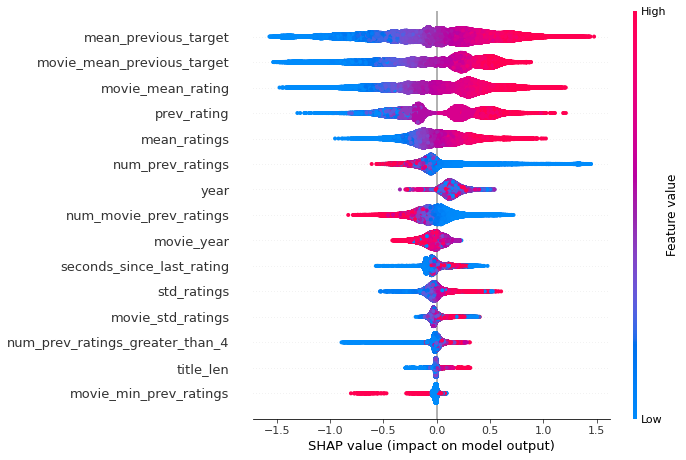

In [115]:
plt.figure(figsize=(16,16))
shap.summary_plot(shap_values.values[:, :, 1], X_test_sample, show=False)
plt.savefig('img/shap_values.png', dpi=300, bbox_inches = 'tight')
plt.show()

- If the user has a high average of rating movies >= 4 that means that his current rate has higher probability of being rated >= 4.
    - This also applies with the previous movie rated and the average of his previous ratings.
- If the movie has a high average of veing ranked >= 4 that means that his probability of being ranked >= 4 is higher.
- Interestingly, if the user has higher number of movies ratings this deacreses the probability of rate the current movie >= 4. This could happen because he's a user who watches a lot of movies, and therefore he's more critical because he has a broader basis for comparison. 
    - Tnis also happens with the number of the movie rates, as the number of ratings increases it is rated with lower rates.
- Also, people tend to rate worse newer movies.
- Movie titles with more characters have higher probability of being rated >= 4

The model focuses on the user's past behavior and the film's reputation, avoiding overfitting to less relevant features.

- Users with a historically high proportion of ratings ≥ 4 are significantly more likely to rate the current movie positively. This behavior is consistently captured through features such as the user’s average past ratings and their previous rating.

- Similarly, movies with a strong historical reputation—measured by the average proportion of ratings ≥ 4—have a higher probability of receiving positive ratings.

- Interestingly, users with a large number of past ratings tend to assign lower scores on average. This likely reflects more critical behavior due to a broader basis for comparison. A similar effect is observed for movies with many past ratings.

- Temporal effects are also present: newer movies tend to receive slightly lower ratings on average.

- Overall, the model relies primarily on the user’s historical behavior and the movie’s past performance, which aligns well with domain intuition and reduces the risk of overfitting to less informative features.